# conditional Auxillary Classifier GAN
Train an auxillary classifier GAN on the MNIST handwritten digit dataset. 

This makes use of: our custom Keras model class defined in
vaegan.gan.py, our class for loading the MNIST dataset defined in
vaegan.data, and our custom Keras callback in vaegan.conditional.callbacks.

A directory called 'output' will be created to save figures and the trained
model. 


In [1]:
nEpochs=20  # orig, longer training
#nEpochs=3  # quick testing during development


In [2]:
!nvidia-smi

Wed May 28 21:07:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:02:00.0 Off |                    0 |
| N/A   25C    P0             29W /  250W |   15787MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Import 3rd party libraries 

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

# Import our own classes 
from vaegan.data import MNIST
from vaegan.conditional.callbacks import GenerateImagesConditional
from vaegan.gan import ConditionalGAN

2025-05-28 21:07:23.639050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748484443.663155   21739 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748484443.670384   21739 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748484443.689115   21739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748484443.689133   21739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748484443.689136   21739 computation_placer.cc:177] computation placer alr

## 3. Show some our data

I0000 00:00:1748484448.204648   21739 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15506 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0
/project/nanocourse/SWE_OOP/train11/Module_2_Materials/04_ExerciseCodeAndInstructions/vaegan/vaegan/data.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


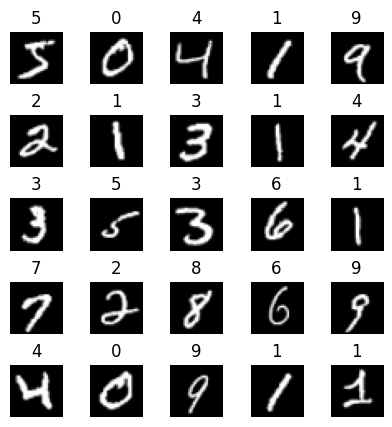

In [4]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist_cgan'
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [5]:
# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
model = ConditionalGAN(n_classes=n_classes)

# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.
model.compute_output_shape([(None, 32, 32, 1), (None, n_classes)])
model.discriminator.compute_output_shape((None, 32, 32, 1))

Loaded version: vaegan.gan
Loaded version: vaegan.gan


(TensorShape([None, 1]), TensorShape([None, 10]))

In [6]:
print("=== OVERALL MODEL ====")
model.summary()
print("=== GENERATOR SUBMODEL ====")
gen_in = tf.keras.layers.Input(model.n_latent_dims+n_classes)
gen_out  = model.generator.call(gen_in) 
gen = tf.keras.Model(gen_in, gen_out) 
gen.summary()
print("=== DISCRIMINATOR SUBMODEL ====")
disc_in = tf.keras.layers.Input(model.image_shape) 
disc_out  = model.discriminator.call(disc_in) 
disc = tf.keras.Model(disc_in, disc_out) 
disc.summary()



=== OVERALL MODEL ====
Model: "cgan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Generator)       multiple                  1664385   
                                                                 
 discriminator (MultiTaskDi  ((None, 1),               213995    
 scriminator)                 (None, 10))                        
                                                                 
Total params: 1878386 (7.17 MB)
Trainable params: 1878188 (7.16 MB)
Non-trainable params: 198 (792.00 Byte)
_________________________________________________________________
=== GENERATOR SUBMODEL ====
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 138)]             0         
                                                                 
 dense (Dense)      

## 6. Compile the model 

In [7]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
save_images_callback = GenerateImagesConditional(output_dir=output_dir, 
                                                 model=model,
                                                 example_labels=labels_onehot[:10],
                                                 n_generated_images=10,
                                                 n_latent_dims=model.n_latent_dims)

## 7. Train (fit) the model on the data 

In [8]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit([data.images_train, labels_onehot],
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])

Epoch 1/20


I0000 00:00:1748484454.872898   21997 cuda_dnn.cc:529] Loaded cuDNN version 90300


469/469 [==============================] - 33s 57ms/step - loss_gen: 12.4915 - loss_disc: 0.7193 - class_accuracy: 0.9193
Epoch 2/20
469/469 [==============================] - 26s 56ms/step - loss_gen: 5.5013 - loss_disc: 0.1190 - class_accuracy: 0.9757
Epoch 3/20
469/469 [==============================] - 26s 56ms/step - loss_gen: 0.1251 - loss_disc: 0.1304 - class_accuracy: 0.9760
Epoch 4/20
469/469 [==============================] - 26s 55ms/step - loss_gen: 23.7242 - loss_disc: 0.3166 - class_accuracy: 0.9778
Epoch 5/20
469/469 [==============================] - 26s 56ms/step - loss_gen: 56.8404 - loss_disc: 0.2953 - class_accuracy: 0.9804
Epoch 6/20
469/469 [==============================] - 27s 57ms/step - loss_gen: 80.2665 - loss_disc: 0.6634 - class_accuracy: 0.9806
Epoch 7/20
469/469 [==============================] - 26s 56ms/step - loss_gen: 8.2500 - loss_disc: 0.2562 - class_accuracy: 0.9843
Epoch 8/20
469/469 [==============================] - 26s 55ms/step - loss_gen: 44.

## 8. Training saves results to disk, now also plot training curves

INFO:tensorflow:Assets written to: ./outputs/mnist_cgan/cgan/assets


INFO:tensorflow:Assets written to: ./outputs/mnist_cgan/cgan/assets


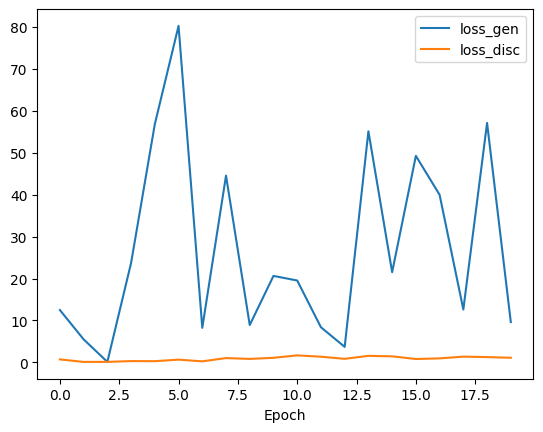

In [9]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['loss_gen', 'loss_disc']:
    loss_values = logs.history[loss_name]
    x = np.arange(len(loss_values))
    ax.plot(x, loss_values, label=loss_name)
    
ax.legend()
ax.set_xlabel('Epoch')
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
# fig.show()

# Save the model 
model.save(os.path.join(output_dir, 'cgan'))
